### Classification Algorithms
This notebook will focus on supervised learning algorithms, specifically classification ones. Using
<a href='https://archive.ics.uci.edu/ml/datasets/auto+mpg'>this UCI's car dataset</a>, I want to tackle the question to
classify the cars based on their origin. The following steps will be discussed and implemented:
- Researching car features
- Exploratory data analysis (EDA)
- Dealing with missing data
- First attempt at Logistic Regression
- PCA
- Multiple algorithms & selecting the best one

- cylinders range, most common: [4, 5, 6, 8], exceptions: [2, 3, 10, 12, 16]
- mpg


Since the dataset has missing values, my main concern is to find them as "I wasn't
aware of them".

In [181]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

%matplotlib inline
sns.set()

In [81]:
cars = pd.read_csv('dataset/auto-mpg.data', delimiter='\s+',
                   names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                          'acceleration', 'model_year', 'origin', 'car_name'])
print(cars.head(3))
cars.info()

    mpg  cylinders  displacement horsepower  weight  acceleration  model_year  \
0  18.0          8         307.0      130.0  3504.0          12.0          70   
1  15.0          8         350.0      165.0  3693.0          11.5          70   
2  18.0          8         318.0      150.0  3436.0          11.0          70   

   origin                   car_name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-n

### As we can see, horsepower is translated as object type, let's analyze it


float64
Missing values: 6


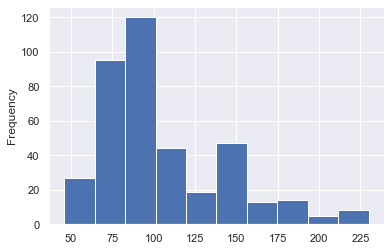

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,NaN,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035.0,20.5,82,1,amc concord dl


In [83]:
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors='coerce')
print(cars['horsepower'].dtype)
print('Missing values:', cars['horsepower'].isna().sum())
missing_values = cars[cars['horsepower'].isna()]

# look at distribution
cars['horsepower'].plot(kind='hist')
plt.show()

# look at missing values
missing_values

Since there are three Fords, two Renault, and one AMC, we can try to look at each of those cars individually

Instead of doing the things below, I want to fill the missing values depending on their values:

<code>cars['horsepower'].fillna(cars['horsepower'].mean(), inplace=True)</code>


In [119]:
fords_4cyl = cars[(cars['car_name'].str.startswith('ford')) & (cars['cylinders'] == 4)]
fords_6cyl = cars[(cars['car_name'].str.startswith('ford')) & (cars['cylinders'] == 6)]
renaults = cars[(cars['car_name'].str.startswith('renault')) & (cars['cylinders'] == 4)]
amc = cars[(cars['car_name'].str.startswith('amc')) & (cars['cylinders'] == 4)]

print(f'Ford 4 cylinder count: {len(fords_4cyl)}')
print(f'Ford 6 cylinder count: {len(fords_6cyl)}')
print(f'Renault 4 cylinder count: {len(renaults)}')
print(f'AMC 4 cylinder count: {len(amc)}\n\n')

fords_4cyl_mean = round(fords_4cyl.horsepower.mean(), 1)
fords_6cyl_mean = round(fords_6cyl.horsepower.mean(), 1)
renault_mean = round(renaults.horsepower.mean(), 1)
amc_mean = round(amc.horsepower.mean(), 1)

print(f'Ford 4 cylinder HORSEPOWER mean: {fords_4cyl_mean}')
print(f'Ford 6 cylinder HORSEPOWER mean: {fords_6cyl_mean}')
print(f'Renault HORSEPOWER mean: {renault_mean}')
print(f'AMC HORSEPOWER mean: {amc_mean}')

# fill missing values
cars.loc[(cars['horsepower'].isna()) & (cars['cylinders'] == 4) & (cars['car_name'].str.startswith('ford')), 'horsepower'] = fords_4cyl_mean
cars.loc[(cars['horsepower'].isna()) & (cars['cylinders'] == 6) & (cars['car_name'].str.startswith('ford')), 'horsepower'] = fords_6cyl_mean
cars.loc[(cars['horsepower'].isna())  & (cars['car_name'].str.startswith('renault')), 'horsepower'] = renault_mean
cars.loc[(cars['horsepower'].isna()) & (cars['car_name'].str.startswith('amc')), 'horsepower'] = amc_mean

Ford 4 cylinder count: 18
Ford 6 cylinder count: 13
Renault 4 cylinder count: 5
AMC 4 cylinder count: 3


Ford 4 cylinder HORSEPOWER mean: 81.1
Ford 6 cylinder HORSEPOWER mean: 88.3
Renault HORSEPOWER mean: 70.0
AMC HORSEPOWER mean: 85.0


Missing values count: 0


## Time to think about distribution of the origin & whether we'll be able to classify them

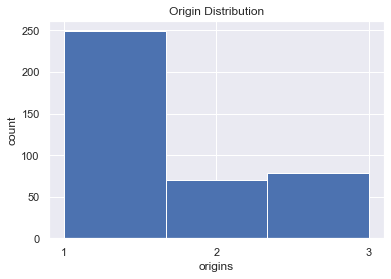

Origin unique values & count:
1    249
3     79
2     70
Name: origin, dtype: int64


In [132]:
# first, plot the distributions
plt.title('Origin Distribution')
cars.origin.plot(kind='hist', bins=3)
plt.xticks([1, 2, 3])
plt.xlabel('origins')
plt.ylabel('count')
plt.show()

print(f'Origin unique values & count:\n{cars.origin.value_counts()}')

In [179]:
# split the data & standardize
X, y = cars.drop(['origin', 'car_name'], axis=1).values, cars['origin'].values

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25, shuffle=True, random_state=42)
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.fit_transform(X_test)

logreg = LogisticRegression().fit(normalized_X_train, y_train)
print('L2 Train Score:', logreg.score(normalized_X_train, y_train))
print('L2Test Score:', logreg.score(normalized_X_test, y_test))

print('\n=================\n')

logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear').fit(normalized_X_train, y_train)
print('L1 Train Score:', logreg.score(normalized_X_train, y_train))
print('L1 Test Score:', logreg.score(normalized_X_test, y_test))


L2 Train Score: 0.7676767676767676
L2Test Score: 0.7190635451505016


L1 Train Score: 0.7676767676767676
L1 Test Score: 0.7190635451505016


### For now, we can see that Logistic Regression has scored 72%
Let's see what we can do better



In [180]:
# gridsearchcv for l2 reg
params = {'C': [0.001, 0.01, 0.1, 1, 10]}

search_cv = GridSearchCV(LogisticRegression(), param_grid=params, cv=5, refit=True).fit(normalized_X_train, y_train)
print(f'L2 Best score: {search_cv.best_score_}')
print(f'L2 Best params: {search_cv.best_params_}')

# gridsearchcv for l1 reg
search_cv_l1 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'),
                            param_grid=params).fit(normalized_X_train, y_train)
print(f'L1 Best score: {search_cv.best_score_}')
print(f'L1 Best params: {search_cv.best_params_}')


L2 Best score: 0.7673684210526315
L2 Best params: {'C': 10}
L1 Best score: 0.7673684210526315
L1 Best params: {'C': 10}


In [150]:
# PCA
corr_metrics = cars.corr()
corr_metrics.style.background_gradient()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.000000,-0.775396,-0.804203,-0.776858,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.950721,0.843276,0.896017,-0.505419,-0.348746,-0.562543
displacement,-0.804203,0.950721,1.000000,0.897568,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.776858,0.843276,0.897568,1.000000,0.864174,-0.687536,-0.416791,-0.450637
weight,-0.831741,0.896017,0.932824,0.864174,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.505419,-0.543684,-0.687536,-0.417457,1.000000,0.288137,0.205873
model_year,0.579267,-0.348746,-0.370164,-0.416791,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.562543,-0.609409,-0.450637,-0.581024,0.205873,0.180662,1.000000


mpg            -0.078149
cylinders       0.187239
displacement    0.181707
horsepower      0.159149
weight          0.194529
acceleration   -0.029975
model_year      0.075725
origin         -0.031704
dtype: float64


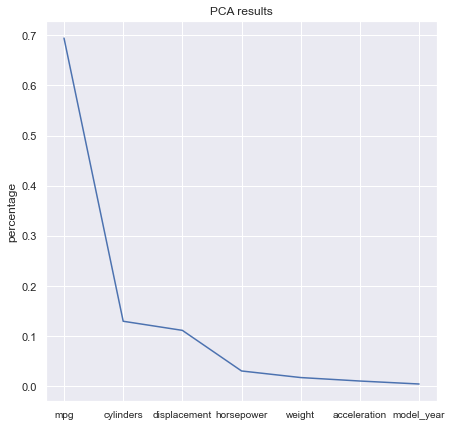

In [209]:
print(corr_metrics.mean())
# pca & logistic regression
pca = PCA().fit(normalized_X_train)
exp_variance = pca.explained_variance_ratio_

xlabels = cars.drop(['origin', 'car_name'], axis=1).columns
plt.figure(figsize=(7, 7))
plt.title('PCA results')
plt.plot(np.arange(len(exp_variance)), exp_variance)
plt.xticks(np.arange(len(xlabels)), xlabels, fontsize=10)
plt.ylabel('percentage')
plt.show()


In [216]:
# pca explained variance
print('Cumulative feature importance', np.cumsum(pca.explained_variance_ratio_))
n_components = 5

pca = PCA(n_components=n_components)
pipeline = make_pipeline(pca, LogisticRegression(C=10)).fit(normalized_X_train, y_train)
print('Train Score:', pipeline.score(normalized_X_train, y_train))
print('Test Score:', pipeline.score(normalized_X_test, y_test))

pca_x_train = pca.transform(normalized_X_train)
pca_x_test = pca.fit_transform(normalized_X_test)

Cumulative feature importance [0.72233113 0.84524268 0.94554895 0.97095586]
Train Score: 0.7070707070707071
Test Score: 0.6722408026755853


Run:
- Logistic Regression
- LinearSVC
- KNearestClassifier
- SVC
- DecisionTreeClassifier
- RandomForestClassifier

In [219]:
def find_best_params(clf, name, x, y):
    if name == 'KNeighborsClassifier':
        parameters = {'n_neighbors': [2, 3, 4, 5, 6, 7],
          'weights': ['uniform', 'distance']}
    elif 'SVC' in name or name == 'LogisticRegression':
        parameters = {'C': [0.001, 0.01, 0.1, 1, 10]}
        if name == 'SVC':
            parameters['gamma'] = [0.0001, 0.001, 0.01, 0.1, 0.1, 1]
    elif name == 'RandomForestClassifier':
        parameters = {'n_estimators': [50, 100, 150],
                      'criterion': ['gini', 'entropy']}
    elif name == 'DecisionTreeClassifier':
        parameters = {'criterion': ['gini', 'entropy'],
                      'splitter': ['random', 'best']}
    return GridSearchCV(clf, parameters, refit=True).fit(x, y)


classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegression(penalty='l1', solver='liblinear', max_iter=1e4),
    SVC(),
    LinearSVC(),
    RandomForestClassifier(),
    DecisionTreeClassifier()
]

clf_names = ['KNeighborsClassifier', 'LogisticRegression', 'LogisticRegression','SVC', 'LinearSVC',
             'RandomForestClassifier', 'DecisionTreeClassifier']
def original_and_pca_results(x, y, x_test, y_test):
    tests = []
    trains = []

    for idx in range(len(classifiers)):
        results = find_best_params(classifiers[idx], clf_names[idx], x, y)
        trains.append(results.score(x, y))
        tests.append(results.score(x_test, y_test))
        print(f'{clf_names[idx]}:\n\t{results.best_params_}')
        print(f'\tTrain Scores: {trains[idx]}'
              f'\n\tTest Scores: {tests[idx]}\n\n')

    return pd.DataFrame({'classifications': clf_names,
                                  'train results': trains,
                                  'test results': tests})


In [221]:
# final_results['difference'] = final_results['train results'] - final_results['test results']
# final_results.sort_values(by='difference')

original_data_results = original_and_pca_results(normalized_X_train, y_train, normalized_X_test, y_test)
pca_data_results = original_and_pca_results(pca_x_train, y_train, pca_x_test, y_test)

original_data_results['difference'] = original_data_results['train results'] - original_data_results['test results']
pca_data_results['difference'] = pca_data_results['train results'] - pca_data_results['test results']

print('Original Data Results:')
print(original_data_results.sort_values(by='difference'))

print('\nPCA Data Results:')
print(pca_data_results.sort_values(by='difference'))

KNeighborsClassifier:
	{'n_neighbors': 6, 'weights': 'uniform'}
	Train Scores: 0.8080808080808081
	Test Scores: 0.6555183946488294


LogisticRegression:
	{'C': 10}
	Train Scores: 0.8282828282828283
	Test Scores: 0.7525083612040134


LogisticRegression:
	{'C': 10}
	Train Scores: 0.8181818181818182
	Test Scores: 0.7324414715719063


SVC:
	{'C': 10, 'gamma': 1}
	Train Scores: 0.98989898989899
	Test Scores: 0.68561872909699


LinearSVC:
	{'C': 10}
	Train Scores: 0.8080808080808081
	Test Scores: 0.7357859531772575


RandomForestClassifier:
	{'criterion': 'entropy', 'n_estimators': 50}
	Train Scores: 1.0
	Test Scores: 0.7290969899665551


DecisionTreeClassifier:
	{'criterion': 'gini', 'splitter': 'best'}
	Train Scores: 1.0
	Test Scores: 0.7023411371237458


KNeighborsClassifier:
	{'n_neighbors': 3, 'weights': 'distance'}
	Train Scores: 1.0
	Test Scores: 0.6488294314381271


LogisticRegression:
	{'C': 0.1}
	Train Scores: 0.7474747474747475
	Test Scores: 0.6622073578595318


LogisticRegression

c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\dinar\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\dinar\appdata\local\program

In [0]:

from sklearn.feature_selection import RFECV

X, y = cars.drop(['car_name', 'origin'], axis=1), cars['origin']

rfecv = RFECV(estimator=LogisticRegression(max_iter=1e5), cv=5, verbose=True).fit(X, y)


In [ ]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(LogisticRegression(max_iter=1e5, penalty='l1', solver='liblinear').fit(X, y), prefit=True)
X_new = model.transform(X)
X_new.shape


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X, y)
print(lda.explained_variance_ratio_)
print(lda.means_)
print(lda.classes_)

In [ ]:
sns.pairplot(cars, hue='origin')
